# **WhisperSpeechSplitter**

OpenAIのwhisperを用いて自動で文字起こしを行い、
そのデータをもとに音源の分割を行います。音源はBGMが除去された声のみの素材が望ましいです。

音声の切り出しを想定していますが、
動画の自動切り出しも可能です(突貫工事)。音声より時間がかかりますが、使えなくはないかも。




<使用方法>

各コードは、"code"と書かれた箇所の下の再生ボタンみたいなやつ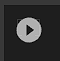を押すと実行できます。


<font color="red">**初回起動時(タイムアウト後も含む?)は、上部「ランタイム」タブ⇒「ランタイムのタイプを変更」⇒「ハードウェアアクセラレータ」が"GPU"になっているか確認してください。**</font>


▼最初はまずこの順で行ってください。(Ctrl+F9で「すべてのセルを実行」してもいいかもしれません)
1.   パッケージのインストール
2.   GoogleDriveのマウント
3.   音源のパスを指定
4.   whisperで文字起こし\
  4-1. モデルの読み込み\
  4-2. 文字起こし\
  (4-3. 文字起こしの結果の編集)
5.   音源の分割

▼連続して2回目以降音源を変えて実行する場合 (※ランタイムがタイムアウトした場合は1.から全部)
3.  音源のパスを指定
4.  4-2. を実行(4-1は不要)
5.  音源の分割







<補足>

2.のマウントが成功すると、画面左側のファイルメニュー内に"drive"が表示されるので、展開して任意の音源ファイルを探してください。右クリックからパスのコピーができます。

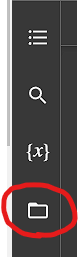

▲コレ


## **1. パッケージのインストール**

In [ ]:
#@title code { display-mode: "form" }
!pip install git+https://github.com/openai/whisper.git
!pip install pydub
!pip install moviepy
!pip install imageio==2.4.1
!pip install pyperclip

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-hqxpw510
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-hqxpw510
  Resolved https://github.com/openai/whisper.git to commit 25639fc17ddc013d56c594bfbf7644f2185fad84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.1 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=df7a1cbd4dcd21bb9198c7baf15e659eb3306532b672e31acdf52a3059fb36b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_u4c7p3t/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.3 MB/s eta 0:00:00

## 2.**GoogleDriveのマウント**
実行すると確認画面みたいなやつが出てきます。

In [ ]:
#@title code { display-mode: "form" }
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **3. 音源のパスを指定**
実行すると入力フィールドが出てくるので、そこにパスを入力してください。

In [ ]:
#@title code { display-mode: "form" }
import os

FILE_PATH = input("音源のファイルパスを入力してください(Enterで確定) >>")
if (os.path.isfile(FILE_PATH)):
  fmt = os.path.splitext(FILE_PATH)[1].replace(".","")
  FILE_NAME =  os.path.splitext(os.path.basename(FILE_PATH))[0]
  DIR_NAME = os.path.dirname(FILE_PATH)
  print( "'" + FILE_NAME + "'" + "を読み込みました。")
else:
  raise FileNotFoundError("指定のファイルパスが見つかりませんでした。")

音源のファイルパスを入力してください(Enterで確定) >>/content/drive/MyDrive/OGIS会議録音.mp3
'OGIS会議録音'を読み込みました。


## **4. Whisperによる文字起こし処理**

### **4-1. モデルの読み込み**

* 一度実行した後は、同じランタイムである限り4-1はスキップして大丈夫です。



In [ ]:
#@title code { display-mode: "form" }
import whisper

model = whisper.load_model("large")


100%|█████████████████████████████████████| 2.88G/2.88G [00:34<00:00, 89.8MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

### **4-2. 文字起こし**

In [ ]:
#@title code { display-mode: "form" }
import pandas as pd

res = model.transcribe(FILE_PATH, verbose=False, language="ja")


speech_data = pd.DataFrame(res["segments"])[["start", "end", "text"]]
pd.set_option("display.max_rows", len(speech_data))
speech_data

100%|██████████| 5913/5913 [00:17<00:00, 342.18frames/s]


,start,end,text
0,0.70,5.24,新製品のターゲット層は30代から40代のビジネスマンに絞りましょう。
1,6.08,8.22,高機能でスタイリッシュなデザインが売りになります。
2,9.56,13.98,でも最近の若い人たちも同じ製品を求めている傾向があると現場の声から聞いています。
3,14.36,16.84,それに価格ももう少し広げた方が…
4,16.84,19.68,いや、30代以上に限定するべきだと思います。
5,20.20,22.44,若い層はどうせ似たようなものを買うでしょう?
6,23.12,27.18,私たちが開発した技術は幅広い年齢層にアピールできるものです。
7,27.18,30.42,技術的にも他の層に響く可能性が…
8,30.42,32.42,でもリソースは限られているんです。
9,33.34,36.04,今のマーケティング戦略を変更する余裕はありません。


### **4-3. 文字起こし結果の編集(任意)**

実行すると文字起こしの結果を編集できます。

<使用方法>


1.   編集メニュー\
    ・行番号入力でその行の要素を編集できます。\
    ・コマンド'tr'で、全セリフから任意のワードを検索し、指定のワードで全置換する機能が使えます。\
    ・コマンド'd'で指定行を削除できます。\
    ・終了するには'e'を入力してください。

2.   行編集\
    ・'s'で分割開始時間、'e'で分割終了時間、't'でセリフを編集できます。\
    ・行編集を終了するには、「入力なし」もしくは上記以外のコマンドを入力してください。

3.   セリフ指定ワード置換(コマンド'tr')\
    ・「置換前ワード」を含むすべてのセリフについて、そのワードが出現する箇所をすべて「置換後ワード」に置き換えます。\
    ・自動文字起こしで、同じ言葉が同じ誤変換となった場合(固有名詞など)に便利です。

  
   <動作例>
   
         <BEFORE>                                                                        <AFTER>
    0 "鈴木が泳いでる"                                                             0 "スズキが泳いでる"

    1 "回転寿司で鈴木を頼む"     =====(置換前:"鈴木" / 置換後: "スズキ")====>      1 "回転寿司でスズキを頼む"

    2 "鈴木の軽自動車"                                                             2 "スズキの軽自動車"

    3 "鈴木スズキススキ鈴木"                                                       3 "スズキスズキススキスズキ"

4.    行削除(コマンド'd')\
    ・指定した行を削除します。\
    ・行削除を終了するには'e'を入力してください。

In [ ]:
#@title code { display-mode: "form" }

from pydub import *
from pydub.playback import play
import IPython.display as ipd
import shutil
import time
import pyperclip as pc

def isFloat(s):
  try:
    float(s)
  except ValueError:
    return False
  else:
    return True

def printDataFrame():
  print("="*200)
  print(speech_data)
  print("="*200)


os.makedirs("tmp_wss", exist_ok=True) #修正作業用の一時フォルダ

source_file = AudioSegment.from_file(FILE_PATH, format=fmt)
printDataFrame()
idx = input(f"◆編集メニュー: 修正するデータの行番号({speech_data.index[0]}～{speech_data.index[-1]})、またはコマンド('tr': セリフ指定ワード置換 / 'd': 行削除)を入力してください。'e'で終了します。>> ")


while idx != 'e':
  if idx.isnumeric():
    idx=int(idx)
    if (idx in speech_data.index):
      splitted_sound = source_file[speech_data["start"][idx]*1000 : speech_data["end"][idx]*1000]
      splitted_sound.export("tmp_wss/tmp.wav")
      print("▼指定の音声")
      ipd.display(ipd.Audio("tmp_wss/tmp.wav", autoplay=True))
      time.sleep(0.5)
      while True:
        colm = input(f"修正箇所を指定(右記以外の入力で終了)⇒ 's':開始時間[sec] / 'e':終了時間[sec] / 't':セリフ>> ")
        if(colm == 's'):
          val = input(f"開始時間を入力してください。(現在値: {speech_data.at[idx, 'start']}) [sec]>> ")
          speech_data.at[idx, 'start'] = float(val) if isFloat(val) else speech_data.at[idx, 'start']
        elif(colm == 'e'):
          val = input(f"終了時間を入力してください。(現在値: {speech_data.at[idx, 'start']}) [sec]>> ")
          speech_data.at[idx, 'end'] = float(val) if isFloat(val) else speech_data.at[idx, 'end']
        elif(colm == 't'):
          val = input(f"セリフを入力してください。(現在値: {speech_data.at[idx, 'text']})>> ")
          speech_data.at[idx, 'text'] = val
        else:
          ipd.clear_output()
          print(f"▼修正完了: {idx}行目")
          print(f"{speech_data['text'][idx]}")
          break
    else:
      ipd.clear_output()


  elif(idx == 'tr'):
    print("指定のワードが出現するすべてのセリフについて、出現箇所を任意のワードで置換します。")
    word_before = input(f"置換前のワードを入力してください: >>")
    tmp_df = speech_data.query('text.str.contains(@word_before)', engine='python')
    word_after = input(f"置換後のワードを入力してください: >>")
    for i in tmp_df.index:
      speech_data.at[i, 'text'] = speech_data.at[i, 'text'].replace(word_before, word_after)
    ipd.clear_output()
    print(f"▼修正完了: {[(str(i)+'行目 ') for i in tmp_df.index]}")
    print(tmp_df)

  elif(idx == 'd'):
    while True:
      speech_data = speech_data.reset_index(drop=True)
      ipd.clear_output()
      printDataFrame()
      val = input(f"削除する行番号({speech_data.index[0]}～{speech_data.index[-1]})を入力してください。'e'で終了します。>> ")
      if val.isnumeric():
        val = int(val)
        if (val in speech_data.index):
          speech_data = speech_data.drop(val) if input(f"{val}行目を削除します。よろしければもう一度行番号({val})を入力してください。異なる入力でキャンセルできます。>>") == str(val) else speech_data
        else:
          print("無効な値です。")
      elif (val == "e"):
        ipd.clear_output()
        break
      else:
        print("無効な値(コマンド)です。")

  else:
    ipd.clear_output()
    print("無効な値(コマンド)です。")

  printDataFrame()
  idx = input(f"◆編集メニュー: 修正するデータの行番号({speech_data.index[0]}～{speech_data.index[-1]})、またはコマンド('tr': セリフ指定ワード置換 / 'd': 行削除)を入力してください。'e'で終了します。>>")


shutil.rmtree("tmp_wss")
ipd.clear_output()
speech_data

,start,end,text
0,0.70,5.24,新製品のターゲット層は30代から40代のビジネスマンに絞りましょう。
1,6.08,8.22,高機能でスタイリッシュなデザインが売りになります。
2,9.56,13.98,でも最近の若い人たちも同じ製品を求めている傾向があると現場の声から聞いています。
3,14.36,16.84,それに価格ももう少し広げた方が…
4,16.84,19.68,いや、30代以上に限定するべきだと思います。
5,20.20,22.44,若い層はどうせ似たようなものを買うでしょう?
6,23.12,27.18,私たちが開発した技術は幅広い年齢層にアピールできるものです。
7,27.18,30.42,技術的にも他の層に響く可能性が…
8,30.42,32.42,でもリソースは限られているんです。
9,33.34,36.04,今のマーケティング戦略を変更する余裕はありません。


## **6.素材の分割(pydub)**

*  セリフで分割された音声(または動画)ファイルが生成されます(※)。音源と同一のディレクトリ内に"(音源名)_split"というフォルダが作成され、この中に出力されます。
*  動画ファイルの分割を行う場合は出力ファイルのフレームレートを選択してください(手入力可)。フレームレートによりますが、<font color="red">**出力に時間がかかります。**</font>



In [ ]:
#@title code { display-mode: "form" }
#@markdown ###動画または音声ファイルの分割処理を行わず，ＣＳＶファイルのみ出力する場合はチェックを入れてください．
dnt_split = False #@param {type:"boolean"}
import math
from moviepy.editor import VideoFileClip
sound_format_list = ["mp3", "wav", "flac", "aac", "flac", "mp2"]
movie_format_list = ["mp4", "mkv", "wmv", "m4v", "avi", "mpg", "mov"]

folder_num = 0

export_dir = f"{DIR_NAME}/{FILE_NAME}_split"
while os.path.isdir(export_dir):
  folder_num += 1
  export_dir = f"{DIR_NAME}/{FILE_NAME}_split_{folder_num}"
os.mkdir(export_dir)

if not dnt_split:
  if fmt in sound_format_list:
    source_file = AudioSegment.from_file(FILE_PATH, format=fmt)
    for i in speech_data.index:
      print(f"\r◆{math.ceil(((i+1)/len(speech_data))*100)}% - Exporting({i+1} of {len(speech_data)}): {i+1}_{speech_data['text'][i]}.{fmt}",end='')
      splitted_sound = source_file[speech_data["start"][i]*1000 : speech_data["end"][i]*1000]
      splitted_sound.export(f"{export_dir}/{i+1}-{speech_data['text'][i]}.{fmt}")


  elif fmt in movie_format_list:
    sourceVideo = VideoFileClip(FILE_PATH)
    #@markdown ###フレームレートを選択(手入力可)
    FPS = "30" #@param [5, 23.98, 24, 25, 29.97, 30, 50, 59.94, 60, 119.88, 120, 240]{allow-input:true}
    print(sourceVideo.fps,"fps")
    for i in speech_data.index:
      print(f"\r◆{math.ceil(((i+1)/len(speech_data))*100)}% - Exporting({i+1} of {len(speech_data)}): {i+1}_{speech_data['text'][i]}.{fmt}"+"\033[9A",end='')
      vid = sourceVideo.subclip(speech_data["start"][i], speech_data["end"][i])
      vid.write_videofile(f"{export_dir}/{i+1}-{speech_data['text'][i]}.{fmt}", fps=float(FPS))
      ipd.clear_output()


  else:
    print("拡張子を確認してください。")

speech_data.to_csv(f"{export_dir}/data.csv", index=True)

print("\r ◆◆ Process Completed. ◆◆")

 ◆◆ Process Completed. ◆◆
